# Predicting NEE on grid

In [1]:
import sys
import xarray as xr
import numpy as np
from joblib import load
from datacube.utils.dask import start_local_dask

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/dea_tools')
from classification import predict_xr

/home/547/cb3058/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
client = start_local_dask(mem_safety_margin='2Gb')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43041,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://127.0.0.1:38903,Total threads: 16
Dashboard: /proxy/43897/status,Memory: 44.92 GiB
Nanny: tcp://127.0.0.1:46075,


### Open model

In [3]:
model = load('/g/data/os22/chad_tmp/NEE_modelling/results/EBF_NEE_model.joblib').set_params(n_jobs=1)

/home/547/cb3058/.local/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/547/cb3058/.local/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Open predictor data

In [4]:
data = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/results/input_data/input_data_2019.nc')

## Open variable names and index data into correct order

TO DO: make this programmatic

In [5]:
f = open("/g/data/os22/chad_tmp/NEE_modelling/results/variables.txt", "r")
variables = f.read()
variables = variables.split(",")
print(variables)

['Ta', 'Sws', 'Fn', 'Precip', 'LAI', 'VPD', 'Ta_L2', 'Sws_L2', 'Fn_L2', 'Precip_L2', 'LAI_L2', 'VPD_L2', '']


In [6]:
data = data[['tavg','soil_moisture','srad','rain','LAI','vpd','tavg_L1','soil_moisture_L1','srad_L1','rain_L1','LAI_L1','vpd_L1']]

### Predict each time-step seperately

- TO DO: fix timesteps that come back from `predict_xr`

In [7]:
# data=data.rename({'latitude':'y', 'longitude':'x'})
mask = ~np.isnan(data.LAI.isel(time=1))


In [8]:
results = []
for i in range(1, len(data)): #start from 1 as forst time-step doesn't have lags
    #print(data.isel(time=i).chunk(dict(x=1000,y=1000)))
    predicted = predict_xr(model,
                        data.isel(time=i).chunk(dict(x=1000,y=1000)),
                        proba=False,
                        clean=True,
                          ).compute()
    
    predicted = predicted.Predictions.where(mask)
    predicted['time'] = data.isel(time=i).time.values
    results.append(predicted)

predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...


In [9]:
nee = xr.concat(results, dim='time')

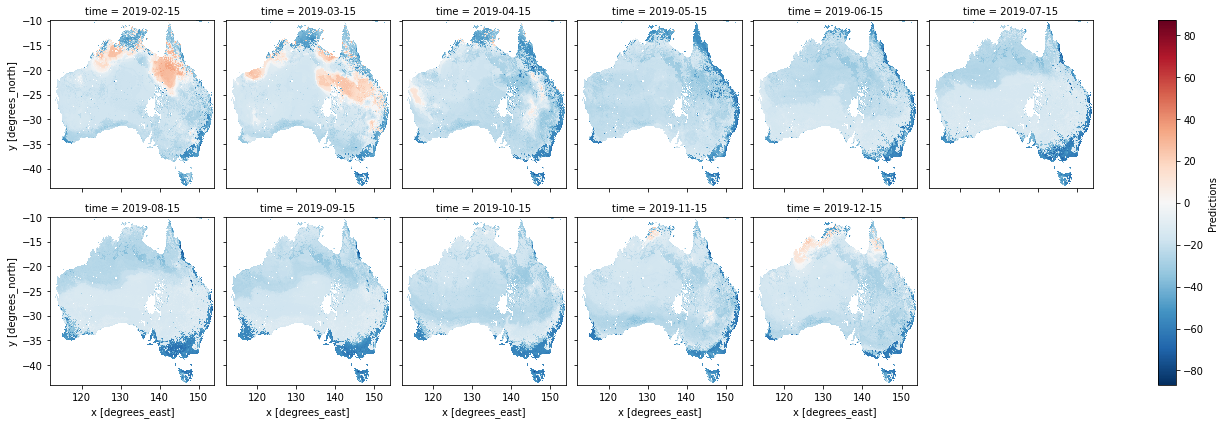

In [10]:
nee.plot.imshow(col='time', col_wrap=6);